<a href="https://colab.research.google.com/github/KIMPOLcode/UAS_AIL/blob/main/DeepBrain_Brain_Tumor_Prediction_Technology_with_VGG16_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import zipfile
import shutil

In [ ]:
# Step 1: Unduh dan ekstrak dataset
# Pastikan Anda telah mengatur kaggle API key
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

# Ekstraksi zip file
with zipfile.ZipFile('brain-mri-images-for-brain-tumor-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('brain_mri')

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 86% 13.0M/15.1M [00:01<00:00, 17.3MB/s]
100% 15.1M/15.1M [00:01<00:00, 10.7MB/s]


Kelas dalam dataset: ['yes', 'no']


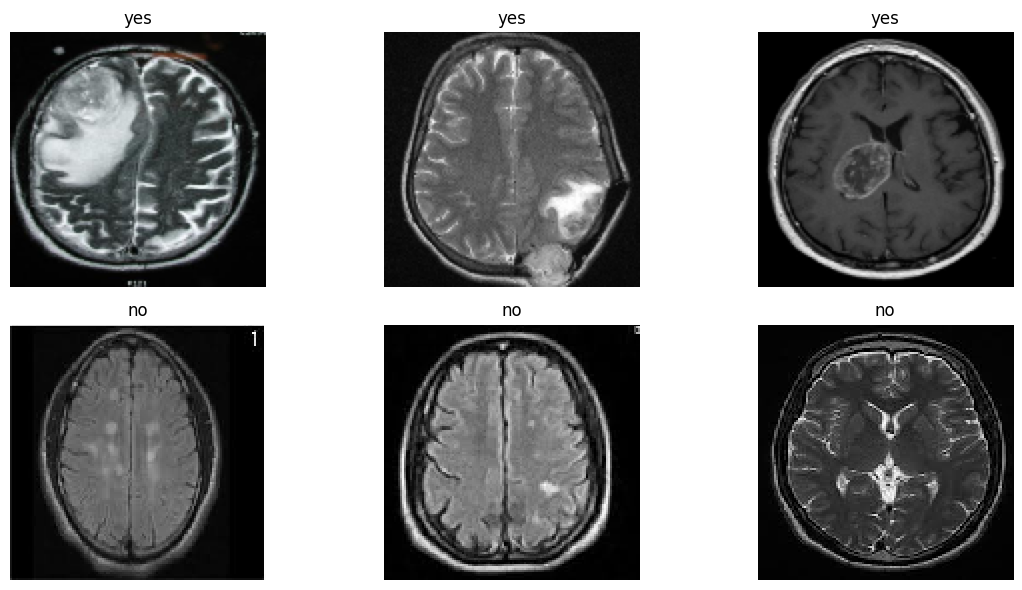

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Direktori dataset
base_dir = 'brain_mri/brain_tumor_dataset'

# Menentukan kelas dalam dataset
classes = os.listdir(base_dir)
print("Kelas dalam dataset:", classes)

# Fungsi untuk menampilkan beberapa gambar dari setiap kelas
def show_sample_images(base_dir, classes, samples_per_class=3):
    plt.figure(figsize=(12, len(classes) * 3))

    for i, cls in enumerate(classes):
        # Ambil daftar file gambar dari kelas ini
        cls_dir = os.path.join(base_dir, cls)
        image_files = os.listdir(cls_dir)[:samples_per_class]

        for j, img_file in enumerate(image_files):
            # Load gambar
            img_path = os.path.join(cls_dir, img_file)
            img = load_img(img_path, target_size=(128, 128))  # Resize gambar (opsional)

            # Tampilkan gambar
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Menampilkan sampel gambar
show_sample_images(base_dir, classes, samples_per_class=3)


Kelas dalam dataset: ['yes', 'no']
Jumlah gambar di yes: 155
Jumlah gambar di no: 98


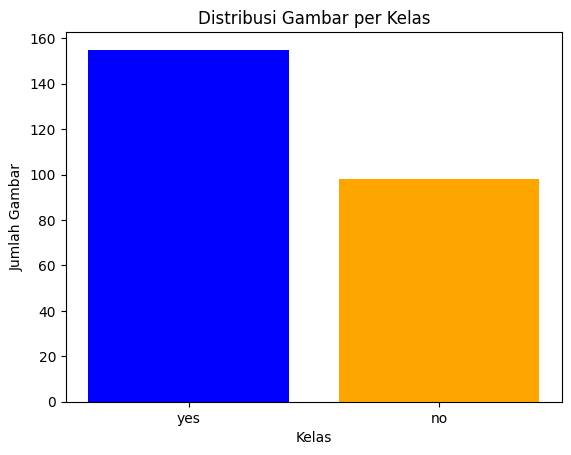

In [ ]:
# Step 2: Pengecekan dataset
base_dir = 'brain_mri/brain_tumor_dataset'
classes = os.listdir(base_dir)
print("Kelas dalam dataset:", classes)

# Hitung jumlah gambar per kelas
class_counts = {}
for cls in classes:
    class_counts[cls] = len(os.listdir(os.path.join(base_dir, cls)))
    print(f"Jumlah gambar di {cls}: {class_counts[cls]}")

# Menampilkan bar chart jumlah gambar per kelas
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])
plt.title('Distribusi Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.show()

In [ ]:
# Step 3: Preprocessing data
# Membagi data menjadi train, validation, dan test
train_dir = 'brain_mri/train'
val_dir = 'brain_mri/val'
test_dir = 'brain_mri/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    images = os.listdir(os.path.join(base_dir, cls))
    np.random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.9 * len(images))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for img in train_images:
        shutil.move(os.path.join(base_dir, cls, img), os.path.join(train_dir, cls, img))

    for img in val_images:
        shutil.move(os.path.join(base_dir, cls, img), os.path.join(val_dir, cls, img))

    for img in test_images:
        shutil.move(os.path.join(base_dir, cls, img), os.path.join(test_dir, cls, img))

In [ ]:
# Data augmentation dan generator
img_height, img_width = 224, 224
batch_size = 32

data_gen = ImageDataGenerator(rescale=1./255)

train_gen = data_gen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = data_gen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = data_gen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 176 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


In [ ]:
# Step 4: Fine-tuning VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze layers dari base model
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan fully connected layers
# Use 'model' variable consistently for the Sequential model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.applications import VGG16

# Menampilkan arsitektur model
print("Arsitektur Model VGG16:")
model.summary()


Arsitektur Model VGG16:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Step 5: Pelatihan model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_steps=val_gen.samples // batch_size
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 113s 25s/step - accuracy: 0.5594 - loss: 0.7300 - val_accuracy: 0.8438 - val_loss: 0.4759
Epoch 2/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 1:12 18s/step - accuracy: 0.4375 - loss: 0.8073

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.4375 - loss: 0.8073 - val_accuracy: 0.6316 - val_loss: 0.5748
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 86s 16s/step - accuracy: 0.6084 - loss: 0.6894
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.8125 - loss: 0.3926 - val_accuracy: 0.8125 - val_loss: 0.4302
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 114s 19s/step - accuracy: 0.8086 - loss: 0.4249 - val_accuracy: 0.7895 - val_loss: 0.4467
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8125 - loss: 0.3391 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 103s 21s/step - accuracy: 0.8346 - loss: 0.3695 - val_accuracy: 0.7812 - val_loss: 0.4448
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.8750 - loss: 0.3280 - val_accuracy: 0.8421 - val_loss: 0.3274
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 85s 17s/step - accuracy: 0.8563 - loss: 0.3086
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.8438 - loss: 0.3899 - val_accuracy: 0.8125 - val_loss: 0.3805
Epoch 11/20


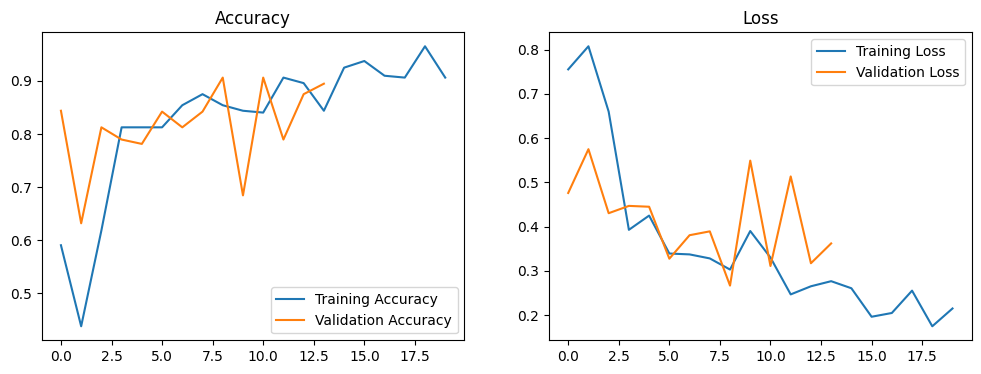

In [ ]:
# Step 6: Evaluasi model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluasi pada test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.8077 - loss: 0.4279
Test Accuracy: 80.77%
Test Loss: 0.4279


In [ ]:
# Save model
model.save('vgg16_brain_mri_model.h5')

In [ ]:
!pip install --upgrade gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = tf.keras.models.load_model('vgg16_brain_mri_model.h5')

# Ensure the model is compiled (if necessary)
if not model.compiled_metrics:
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Function to process the input image and make predictions
def predict(image_file):
    try:
        # Load the image
        img = image.load_img(image_file, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Normalize the image
        img_array /= 255.0

        # Predict using the model
        prediction = model.predict(img_array)

        # Binary classification: Tumor (1) or No Tumor (0)
        if prediction[0][0] > 0.5:
            return "Tumor Ditemukan"
        else:
            return "Tidak Ada Tumor"
    except Exception as e:
        return f"Error: {str(e)}"

# Create the Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(label="Upload Gambar CT Scan", type="filepath"),
    outputs=gr.Textbox(label="Hasil Prediksi"),
    title="Prediksi Tumor Otak",
    description="Upload gambar CT Scan untuk memprediksi apakah ada tumor otak."
)

# Run the web application
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dc5244f78c1756b7f2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
